# Segmenting and Clustering Neighborhoods in Toronto

In this assignment we explore and cluster the neighborhoods in Toronto based on venues they have.
Data of neigbourhoods is taken from [here](https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M). And data of venues is taken from Foursquare

In [1]:
import pandas as pd
import numpy as np

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

import folium

from geopy.geocoders import Nominatim

from sklearn.cluster import KMeans

import matplotlib.cm as cm
import matplotlib.colors as colors


In [2]:
url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
toronto_neigh = pd.read_html(url)

In [3]:
len(toronto_neigh)

3

`toronto_neigh` contains more than one table, but we need only the first one

In [4]:
# Just to show that the rest is another table from wiki page:
toronto_neigh[1].head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,NaN,Canadian postal codes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NL NS PE NB QC ON MB SK AB BC NU/NT YT A B C E...,NL NS PE NB QC ON MB SK AB BC NU/NT YT A B C E...,NL NS PE NB QC ON MB SK AB BC NU/NT YT A B C E...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NL,NS,PE,NB,QC,QC,QC,ON,ON,ON,ON,ON,MB,SK,AB,BC,NU/NT,YT
3,A,B,C,E,G,H,J,K,L,M,N,P,R,S,T,V,X,Y


In [5]:
toronto_neigh[0].head()

,Postal Code,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"


Now let's create a new dataframe with cleaned "Borough"

In [6]:
toronto_data = toronto_neigh[0][toronto_neigh[0]['Borough']!='Not assigned']
toronto_data.head()

,Postal Code,Borough,Neighbourhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"
5,M6A,North York,"Lawrence Manor, Lawrence Heights"
6,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


Let's set neighbourhood with 'Not assigned' to value in 'Borough'

In [7]:
toronto_data.loc[toronto_data['Neighbourhood'].eq('Not assigned'),'Neighbourhood'] = toronto_data.loc[
                 toronto_data['Neighbourhood'].eq('Not assigned'),'Borough']

/home/akleimenova/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/home/akleimenova/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Check the final dataframe: 

In [8]:
toronto_data.loc[toronto_data['Borough']=='Not assigned']

,Postal Code,Borough,Neighbourhood


In [9]:
toronto_data.loc[toronto_data['Neighbourhood']=='Not assigned']

,Postal Code,Borough,Neighbourhood


And its size:

In [10]:
toronto_data.shape

(103, 3)

Now let's get the latitude and the longitude coordinates of each neighborhood

In [11]:
import geocoder
g = geocoder.google('{}, Toronto, Ontario'.format('M3A'))
g

<[REQUEST_DENIED] Google - Geocode [empty]>

Unfortunately `geocoder` is not working. The following code enters infinite loop

In [12]:
# initialize your variable to None
# lat_lng_coords = None
# postal_code = 'Mountain View, CA'

# # loop until you get the coordinates
# while(lat_lng_coords is None):
#   g = geocoder.google('{}, Toronto, Ontario'.format(postal_code))
#   lat_lng_coords = g.latlng

# latitude = lat_lng_coords[0]
# longitude = lat_lng_coords[1]

So let's just read geo data from csv file:

In [13]:
tornto_geo = pd.read_csv('https://cocl.us/Geospatial_data')

In [14]:
tornto_geo.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [15]:
tornto_geo.shape

(103, 3)

Data in `tornto_geo` looks sorted on **Postal code**, so let's sort 'toronto_data' as well:

In [16]:
toronto_data = toronto_data.sort_values('Postal Code')
toronto_data.head()

,Postal Code,Borough,Neighbourhood
9,M1B,Scarborough,"Malvern, Rouge"
18,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek"
27,M1E,Scarborough,"Guildwood, Morningside, West Hill"
36,M1G,Scarborough,Woburn
45,M1H,Scarborough,Cedarbrae


Now we can merge two dataframes to get lattitude and longitude data:

In [17]:
toronto_full = toronto_data.join(tornto_geo.set_index('Postal Code'), on='Postal Code')
toronto_full.head()

,Postal Code,Borough,Neighbourhood,Latitude,Longitude
9,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353
18,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497
27,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
36,M1G,Scarborough,Woburn,43.770992,-79.216917
45,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


In [18]:
toronto_full.shape

(103, 5)

In [19]:
# Just a small check:
toronto_full.dropna().shape

(103, 5)

Now let's have a look at the map of all neighbourhoods we have

In [20]:
address = 'Toronto, Ontario'
geolocator = Nominatim(user_agent="Toronto_test")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


In [21]:
# Function to create map using latitude and longitude values:
def show_map(lat_center, lng_center, zoom, data):
    map_toronto = folium.Map(location=[lat_center, lng_center], zoom_start=zoom)
    for lat, lng, borough, neighborhood in zip(data['Latitude'], 
                                              data['Longitude'], 
                                              data['Borough'], 
                                              data['Postal Code']):
        label = '{}, {}'.format(neighborhood, borough)
        label = folium.Popup(label, parse_html=True)
        folium.CircleMarker(
            [lat, lng],
            radius=5,
            popup=label,
            color='blue',
            fill=True,
            fill_color='#3186cc',
            fill_opacity=0.7,
            parse_html=False).add_to(map_toronto)
    return map_toronto

In [22]:
map_full = show_map(latitude, longitude, 10, toronto_full)
map_full

For simplicity let's check all boroughs that contain Toronto word in it:

In [23]:
toronto_df = toronto_full[toronto_full['Borough'].str.contains('Toronto')]
toronto_df.head()

,Postal Code,Borough,Neighbourhood,Latitude,Longitude
30,M4E,East Toronto,The Beaches,43.676357,-79.293031
66,M4K,East Toronto,"The Danforth West, Riverdale",43.679557,-79.352188
75,M4L,East Toronto,"India Bazaar, The Beaches West",43.668999,-79.315572
84,M4M,East Toronto,Studio District,43.659526,-79.340923
93,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790


Let's see how many postal codes we have in boroughs with Toronto

In [24]:
toronto_df.shape

(39, 5)

Let's see it on a map:

In [25]:
map_toronto = show_map(latitude, longitude, 10, toronto_df)
map_toronto

Now it's time to explore neghbourhoods in the Toronto area!

To begin with, let's set my Foursquare credentials:

In [33]:
CLIENT_ID = '1REU3BIRLKQ0QC31AMKZKGNBHOQIYATZ442LUSKKBWYUDPWB' # your Foursquare ID
CLIENT_SECRET = 'ZPPWAZL1DX4C0433XOFDEHQRJGUIBUMGUQ42X05GYAJ4E0EU' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value
radius = 500 # Set radius to 500m

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 1REU3BIRLKQ0QC31AMKZKGNBHOQIYATZ442LUSKKBWYUDPWB
CLIENT_SECRET:ZPPWAZL1DX4C0433XOFDEHQRJGUIBUMGUQ42X05GYAJ4E0EU


I will copy a function to get venues from the lab:

In [35]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
#         print(requests.get(url).json())
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Postal Code', 
                  'Latitude', 
                  'Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Instead of neighbourhoods, I will use postal codes, since there can be multiple neighbourhoods assigned to a single postal code:

In [36]:
toronto_venues = getNearbyVenues(toronto_df['Postal Code'], toronto_df['Latitude'], toronto_df['Longitude'])
toronto_venues.head()

M4E
M4K
M4L
M4M
M4N
M4P
M4R
M4S
M4T
M4V
M4W
M4X
M4Y
M5A
M5B
M5C
M5E
M5G
M5H
M5J
M5K
M5L
M5N
M5P
M5R
M5S
M5T
M5V
M5W
M5X
M6G
M6H
M6J
M6K
M6P
M6R
M6S
M7A
M7Y


,Postal Code,Latitude,Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,M4E,43.676357,-79.293031,Glen Manor Ravine,43.676821,-79.293942,Trail
1,M4E,43.676357,-79.293031,The Big Carrot Natural Food Market,43.678879,-79.297734,Health Food Store
2,M4E,43.676357,-79.293031,Grover Pub and Grub,43.679181,-79.297215,Pub
3,M4E,43.676357,-79.293031,Upper Beaches,43.680563,-79.292869,Neighborhood
4,M4K,43.679557,-79.352188,MenEssentials,43.677820,-79.351265,Cosmetics Shop


In [37]:
toronto_venues.shape

(1585, 7)

In [38]:
toronto_venues.groupby('Postal Code').count()

,Latitude,Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Postal Code,,,,,,
M4E,4,4,4,4,4,4
M4K,42,42,42,42,42,42
M4L,20,20,20,20,20,20
M4M,36,36,36,36,36,36
M4N,3,3,3,3,3,3
M4P,8,8,8,8,8,8
M4R,18,18,18,18,18,18
M4S,34,34,34,34,34,34
M4T,3,3,3,3,3,3


In [39]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 229 uniques categories.


In [40]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Postal Code'] = toronto_venues['Postal Code'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

,Postal Code,Adult Boutique,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bike Rental / Bike Share,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Business Service,Butcher,Café,Cajun / Creole Restaurant,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Cafeteria,College Gym,College Rec Center,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hookah Bar,Hospital,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Market,Martial Arts School,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Museum,Music Venue,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Restaurant,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soup Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Tibetan Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Yoga Studio
0,M4E,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1,M4E,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [41]:
toronto_onehot.shape

(1585, 230)

Now let's find mean freaquency of the venue in the neighbourhoods with the same post code

In [42]:
toronto_grouped = toronto_onehot.groupby('Postal Code').mean().reset_index()
toronto_grouped

,Postal Code,Adult Boutique,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bike Rental / Bike Share,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Business Service,Butcher,Café,Cajun / Creole Restaurant,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Cafeteria,College Gym,College Rec Center,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hookah Bar,Hospital,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Market,Martial Arts School,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Museum,Music Venue,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Restaurant,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soup Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Tibetan Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Yoga Studio
0,M4E,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00

Check that the number of rows is the same as in `toronto_df`

In [43]:
toronto_grouped.shape

(39, 230)

Now let's see which are top 10 venues in each post code. For this I will do a separate dataframe and use the same code from the lab

In [44]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [45]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Postal Code']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Postal Code'] = toronto_grouped['Postal Code']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], 
                                                                          num_top_venues)

neighborhoods_venues_sorted.head()

,Postal Code,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M4E,Neighborhood,Health Food Store,Trail,Pub,Dance Studio,Eastern European Restaurant,Dumpling Restaurant,Donut Shop,Doner Restaurant,Dog Run
1,M4K,Greek Restaurant,Coffee Shop,Italian Restaurant,Furniture / Home Store,Restaurant,Ice Cream Shop,Cosmetics Shop,Brewery,Bubble Tea Shop,Café
2,M4L,Fast Food Restaurant,Park,Pizza Place,Gym,Sushi Restaurant,Food & Drink Shop,Ice Cream Shop,Fish & Chips Shop,Italian Restaurant,Liquor Store
3,M4M,Coffee Shop,Brewery,Gastropub,Café,Bakery,American Restaurant,Neighborhood,Seafood Restaurant,Cheese Shop,Clothing Store
4,M4N,Park,Swim School,Bus Line,Yoga Studio,Department Store,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Donut Shop,Doner Restaurant


Now we can proceed with clustering. I will take k equal to 4 here

In [46]:
kclusters = 4

toronto_grouped_clustering = toronto_grouped.drop('Postal Code', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([0, 2, 2, 2, 0, 2, 2, 2, 3, 2], dtype=int32)

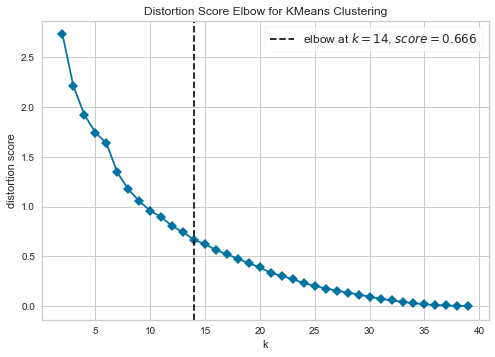

/home/akleimenova/anaconda3/lib/python3.7/site-packages/sklearn/base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


KElbowVisualizer(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7f97177d3590>,
                 k=None, model=None, timings=False)

In [47]:
from yellowbrick.cluster.elbow import kelbow_visualizer
kelbow_visualizer(KMeans(random_state=0), toronto_grouped_clustering, k=(2,40), timings=False)

In [48]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_merged = toronto_df

# add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Postal Code'), on='Postal Code')

toronto_merged.head() # check the last columns!

,Postal Code,Borough,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
30,M4E,East Toronto,The Beaches,43.676357,-79.293031,0,Neighborhood,Health Food Store,Trail,Pub,Dance Studio,Eastern European Restaurant,Dumpling Restaurant,Donut Shop,Doner Restaurant,Dog Run
66,M4K,East Toronto,"The Danforth West, Riverdale",43.679557,-79.352188,2,Greek Restaurant,Coffee Shop,Italian Restaurant,Furniture / Home Store,Restaurant,Ice Cream Shop,Cosmetics Shop,Brewery,Bubble Tea Shop,Café
75,M4L,East Toronto,"India Bazaar, The Beaches West",43.668999,-79.315572,2,Fast Food Restaurant,Park,Pizza Place,Gym,Sushi Restaurant,Food & Drink Shop,Ice Cream Shop,Fish & Chips Shop,Italian Restaurant,Liquor Store
84,M4M,East Toronto,Studio District,43.659526,-79.340923,2,Coffee Shop,Brewery,Gastropub,Café,Bakery,American Restaurant,Neighborhood,Seafood Restaurant,Cheese Shop,Clothing Store
93,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790,0,Park,Swim School,Bus Line,Yoga Studio,Department Store,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Donut Shop,Doner Restaurant


Now let's put it on a map and see the clusters

In [ ]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], 
                                  toronto_merged['Longitude'], 
                                  toronto_merged['Postal Code'], 
                                  toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

Interestingly, majority of neighbourhoods appearead in the same cluster, cluster 0. Let's print each cluster and see why they are similar

### Cluster 1

These neighbourhoods have highest % of parks among all other:

In [ ]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, 
                   toronto_merged.columns[[0] + [2] + list(range(6, toronto_merged.shape[1]))]]

### Cluster 2
Clustered by *Home service*, no other post code has this venue

In [ ]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, 
                   toronto_merged.columns[[0] + [2] + list(range(6, toronto_merged.shape[1]))]]

### Cluster 3
These neighbourhoods have a lot of coffee shops, pubs, restaurants etc.

In [ ]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, 
                   toronto_merged.columns[[0] + [2] + list(range(6, toronto_merged.shape[1]))]]

### Cluster 4
These neighbourhoods seem to have only lawyers and restaurants.

In [ ]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 3, 
                   toronto_merged.columns[[0] + [2] + list(range(6, toronto_merged.shape[1]))]]